# Heart Disease Detection: A CART-Based Binary Classification Model

### Name: Yixun Kang, David Ning, Liang Zhang

### Team: UC Providence

### Link to the github repo: https://github.com/ihiroo/DATA2060_Final_Project

In [1]:
# Dependencies
import numpy as np
from sklearn.datasets import load_iris
from graphviz import Digraph
from sklearn import tree
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold

In [2]:
# Set seed for python and numpy
np.random.seed(0)
random.seed(0)

# Overview:

### 1 Overview
#### 1.1 CART
Classification and Regression Trees (CART) is a supervised machine learning algorithm that constructs decision trees to make predictions. In this project, CART is employed for binary classification, where the target variable has only two possible outcomes. Also compared against a previous work which has multi-class target.

CART models are highly interpretable because the decision rules can be visualizes as a tree structure, containing decision nodes and leaf nodes. When building up the tree, CART can handle both continuous and categorical features without complex preprocessing. Moreover, CART is non-parametric as it does not assume any specific distribution for the data, and can handle non-linear relationships. Since our dataset contains 11 continuous features and 2 categorical features, and we are working with a relatively small dataset, CART is a suitable choice. Its ability to handle mixed data types seamlessly and its efficiency on smaller datasets make it an effective and practical algorithm for this task.

While CART offers many advantages, it also has notable limitations. One major drawback is its tendency to overfit the training data, especially when the tree grows too deep. This can lead to poor generalization on unseen data, making techniques like pruning essential. Additionally, CART is instable, as even small changes in the training data can result in significant variations in the tree structure. Finally, while CART is effective for many problems, its predictive performance may fall short compared to more advanced ensemble methods like Random Forest or Boosting, which can leverage multiple trees to produce more robust predictions.
#### 1.2 Data
The dataset for this project is the Heart Disease dataset, sourced from UCI Machine Learning Repository [2]. It's target variable is binary, with a value of 0 indicating the absence of heart disease and a value of 1 indicating its presence. The dataset contains 13 features that capture a variety of patient characteristics and diagnostic indicators, including both continuous, ordinal and categorical variables. Since ordinal features are encoded as numeric values, they will be treated as continuous features in the modeling process. For features `sex` and `exang`, they are binary categorical but are encoded as numeric values as well.

This project will also use the Iris dataset, sourced from UCI Machine Learning Repository [1] to compare the implementation from scratch with the Scikit-learn model. The Iris dataset contains 4 continuous features. Its target variable is categorical, with 3 classes, representing the species of the iris flower. 

#### 1.3 Representation
## Add algo pic from PPT
#### 1.4 Loss
#### 1.5 Optimizer: Pruning

# Model Section

In [224]:
class Node:
    '''
    Constructor for the Node class
    '''
    def __init__(self, left=None, right=None, label=None, feature=None, threshold=None, parent_gini=None, node_gini=None, num_samples=None, class_counts=None):
        self.left = left # to a left node
        self.right = right # to a right node
        self.label = label
        self.feature = feature
        self.threshold = threshold
        self.parent_gini = parent_gini
        self.node_gini = node_gini
        self.num_samples = num_samples # data points in this node
        self.class_counts = class_counts

    def is_leaf(self):
        '''
        check if the node is a leaf node
        '''
        return self.label is not None

In [229]:
class CART:
    '''
    Decision Tree classifier by UC Providence
    '''
    def __init__(self, max_depth=None, min_samples_split=2, ccp_alpha=0.01, random_state=0):
        if max_depth is None:
            self.max_depth = 20
        else:
            self.max_depth = max_depth # set the max depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.ccp_alpha = ccp_alpha # for pruning
        self.random_state = random_state
        if random_state is not None: # make random state deterministic
            np.random.seed(random_state)
            random.seed(random_state)
        
    def fit(self, data):
        '''
        build the tree based on the data
        '''
        self.tree = self._build_tree(data, depth=0)
    
    def prune(self, data, ccp_alpha=0):
        '''
        prune the tree based on the ccp_alpha
        '''
        self._prune_tree( data, self.tree, ccp_alpha)
    
    def predict(self, data):
        '''
        Helper function to predict the data
        '''
        X = data[:, :-1] # get the features
        return np.array([self._predict_row(self.tree, row) for row in X])

    def loss(self, data):
        '''
        Helper function to calculate the loss
        '''
        preds = self.predict(data)
        true_labels = data[:, -1] # last column is the label
        return np.sum(preds != true_labels) / len(true_labels)

    def accuracy(self, data):
        '''
        Helper function to calculate the accuracy
        '''
        return 1 - self.loss(data)
    
    def _gini_for_node(self, data):
        '''
        Get the gini index for a node
        params data: the data in the node
        return: the gini index
        '''
        labels = data[:, -1] # get the last column which is the label
        _, counts = np.unique(labels, return_counts=True)
        probs = counts / len(labels)
        parent_gini = 1 - np.sum(probs ** 2) # calculate the gini index
        return parent_gini

    def _gini_for_split(self, data, left, right):
        '''
        Get the gini index for a split
        params data: the data in the node
        params left: the left split
        params right: the right split
        return: the gini index
        '''
        # calc the total size
        total_size = len(data)
        left_size = len(left)
        right_size = len(right)
        # calc the gini index for the left and right
        left_gini = self._gini_for_node(left)
        right_gini = self._gini_for_node(right)
        # calc the weighted gini index
        weighted_gini = (left_size / total_size) * left_gini + (right_size / total_size) * right_gini
        return weighted_gini

    def _split(self, data, feature_index, threshold):
        '''
        Split the data based on the feature and threshold
        params data: the data
        params feature_index: the feature to split on
        params threshold: the threshold to split on
        return: the left and right split
        '''
        left = data[data[:, feature_index] <= threshold]
        right = data[data[:, feature_index] > threshold]
        return left, right

    def _find_best_split(self, data):
        '''
        Find the best split for the data, traverse through each column and each average value of the values in the column to find the best split.
        params data: the dataset
        return: the best gain and the best split
        '''
        best_gain = float("-inf")
        best_split = None
        best_split_list = [] # for ties
        parent_gini = self._gini_for_node(data) # calc the gini index for the parent node
        n_features = data.shape[1] - 1
        for feature in range(n_features): # traverse through each feature
            unique_values = np.unique(data[:, feature])
            sorted_values = np.sort(unique_values)
            thresholds = (sorted_values[1:] + sorted_values[:-1]) / 2 # get the average of the values

            if len(thresholds) > 2:
                # Continuous or ordinal features
                for threshold in thresholds:
                    left, right = self._split(data, feature, threshold)
                    if len(left) == 0 or len(right) == 0:
                        continue # skip if the split is empty
                    weighted_gini = self._gini_for_split(data, left, right) # calc the weighted gini index
                    gain = parent_gini - weighted_gini
                    if gain > best_gain: # if the gain is better than the best gain
                        best_gain = gain
                        best_split_list = [{
                            "feature": feature,
                            "threshold": threshold,
                            "gini_for_split": weighted_gini,
                            "parent_gini": parent_gini,
                            "gain": gain,
                            "left": left,
                            "right": right,
                            "type": "continuous"
                        }]
                    elif np.isclose(gain, best_gain):    
                        best_gain = gain
                        best_split_list.append({
                            "feature": feature,
                            "threshold": threshold,
                            "gini_for_split": weighted_gini,
                            "parent_gini": parent_gini,
                            "gain": gain,
                            "left": left,
                            "right": right,
                            "type": "continuous"
                        }) # if tied, then append to the list
            else:
                # Only one threshold for binary features
                for threshold in thresholds:
                    left, right = self._split(data, feature, threshold)
                    if len(left) == 0 or len(right) == 0:
                        continue
                    weighted_gini = self._gini_for_split(data, left, right)
                    gain = parent_gini - weighted_gini
                    if gain > best_gain:    
                        best_gain = gain
                        # same for binary features but with different type
                        best_split_list = [{
                            "feature": feature,
                            "threshold": threshold,
                            "gini_for_split": weighted_gini,
                            "parent_gini": parent_gini,
                            "gain": gain,
                            "left": left,
                            "right": right,
                            "type": "binary"
                        }]
                    elif np.isclose(gain, best_gain):    
                        best_gain = gain
                        best_split_list.append({
                            "feature": feature,
                            "threshold": threshold,
                            "gini_for_split": weighted_gini,
                            "parent_gini": parent_gini,
                            "gain": gain,
                            "left": left,
                            "right": right,
                            "type": "binary"
                        })
        if len(best_split_list) > 1:
            # if the best split list has more than one best split then we sort it by feature
            #print("Multiple best splits found")
            #x = sorted(best_split_list, key=lambda x: x["feature"])
            # for i in x:
            #     print(i["feature"], i["threshold"], i["gini_for_split"], i["parent_gini"], i["gain"])
            best_split = sorted(best_split_list, key=lambda x: x["feature"])[-1]
        else: # else we just get the first best split
            best_split = best_split_list[0]
        return best_gain, best_split

    def _majority_class(self, data):
        '''
        Get the majority class in the data
        '''
        labels = data[:, -1] # get the labels
        unique_labels, counts = np.unique(labels, return_counts=True)
        return unique_labels[np.argmax(counts)]

    def _build_tree(self, data, depth=0):
        '''
        Build the tree recursively
        params data: the data
        params depth: the depth of the tree
        return: the node and its attributes
        '''
        labels = data[:, -1] # label is the last column
        num_samples = len(labels)
        parent_gini = self._gini_for_node(data)

        # Stopping conditions
        # Having a pure node
        if len(np.unique(labels)) == 1:
            return Node(label=labels[0], parent_gini=parent_gini, num_samples=num_samples)
        # Max depth reached
        if self.max_depth is not None and depth >= self.max_depth:
            return Node(label=self._majority_class(data), parent_gini=parent_gini, num_samples=num_samples)
        # Minimum samples split reached
        if num_samples < self.min_samples_split:
            return Node(label=self._majority_class(data), parent_gini=parent_gini, num_samples=num_samples)
        # No split found
        best_gain, best_split = self._find_best_split(data)
        if best_gain == 0:
            return Node(label=self._majority_class(data), parent_gini=parent_gini, num_samples=num_samples)

        # Put left and right data into the tree
        if best_split["type"] == "binary":
            remaining_left = best_split["left"]
            remaining_right = best_split["right"]
        else:
            remaining_left = best_split["left"]
            remaining_right = best_split["right"]
            
        # Recursion
        left_tree = self._build_tree(remaining_left, depth + 1)
        right_tree = self._build_tree(remaining_right, depth + 1)
                
        return Node(
            left=left_tree,
            right=right_tree,
            feature=best_split["feature"],
            threshold=best_split["threshold"], 
            parent_gini=parent_gini,
            num_samples=num_samples
        )

    def _predict_row(self, node, row):
        '''
        recursively predict the row
        params node: the node
        params row: the row
        return: the prediction
        '''
        if node.is_leaf():
            return node.label
        else:
            if row[node.feature] <= node.threshold:
                return self._predict_row(node.left, row)
            else:
                return self._predict_row(node.right, row)
    
    def _count_leaves(self, node):
        '''Helper function to count the number of leaves in a subtree'''
        if node.is_leaf():
            return 1
        else:
            return self._count_leaves(node.left) + self._count_leaves(node.right)
        
    def _prune_tree(self, data, node, ccp_alpha):
        """
        Recursively prune the tree based on cost complexity pruning.
        
        Cost(T) = R(T) + α * |T|
        R(T): sum of (parent_gini * num_samples) over all leaves of subtree T
        |T|: number of leaves in subtree T

        For a node:
        - Cost_subtree = R(subtree) + α * (leaves_subtree)
        - Cost_leaf = (node.parent_gini * node.num_samples) + α * 1

        If Cost_leaf <= Cost_subtree, we prune (make node a leaf).
        """

        # If leaf, nothing to prune
        if node.is_leaf():
            return

        # Compute the cost of the current subtree
        leaves_subtree = self._count_leaves(node)
        R_t = node.parent_gini * node.num_samples / len(data)
        
        # Compute the cost if we prune this node into a leaf
        R_Tt = self._subtree_impurity(node)
        
        # Compare to decide if we prune
        # print(node.parent_gini, node.num_samples, len(data), R_Tt)
        # print(ccp_alpha > (R_t - R_Tt) / (leaves_subtree - 1))
        if ccp_alpha > (R_t - R_Tt) / (leaves_subtree - 1):
            node.left = None
            node.right = None
            node.feature = None
            node.threshold = None
            node.label = self._majority_class(data)
            
        if node.left is not None and node.right is not None:    
            self._prune_tree(data, node.left, ccp_alpha)
            self._prune_tree(data, node.right, ccp_alpha)
                
    def _subtree_impurity(self, node):
        if node.is_leaf():
            print(node.parent_gini, node.num_samples)
            return node.parent_gini * node.num_samples
        else:
            return self._subtree_impurity(node.left) + self._subtree_impurity(node.right)
    

# Check Model Section:

Unit Tests:

In [5]:
# Unit Tests here:

In [230]:
def visualize_tree(tree, size=(10, 10)):
    """
    Visualize the decision tree
    param tree: the decision tree
    return: the graph of the decision tree
    additional reference: https://graphviz.readthedocs.io/en/stable/manual.html
    """
    dot = Digraph(format="png")
    dot.attr(size=str(size))
    def add_nodes_edges(node, dot, counter):
        """
        Add nodes and edges to the graph
        param node: the node of the decision tree
        param dot: the graph
        param counter: the counter
        return: the counter, which serves as the node id, required
        """
        if node is None:
            return counter # Check if the node is None
        node_id = str(counter)

        if node.is_leaf():
            label = f"Label: {node.label}\nGini: {node.parent_gini:.3f}\nSamples: {node.num_samples}"
        else:
            label = (f"Feature {node.feature} ≤ {node.threshold:.2f}\n"
                     f"Gini: {node.parent_gini:.3f}\n"
                     f"Samples: {node.num_samples}")
        # display the node
        dot.node(node_id, label) # add node to the graph
        counter += 1 # increment the counter which is the node id

        if node.left:
            left_id = str(counter)
            counter = add_nodes_edges(node.left, dot, counter)
            dot.edge(node_id, left_id, label="True")
        if node.right:
            right_id = str(counter)
            counter = add_nodes_edges(node.right, dot, counter)
            dot.edge(node_id, right_id, label="False")
        # recursively add nodes and edges
        return counter
    add_nodes_edges(tree.tree, dot, 0)
    return dot # get the graph and return

### Testing iris, a previous work implementation
input the entire dataset as training!

In [231]:
iris = load_iris() # use the iris dataset from sklearn
X = iris.data
y = iris.target
iris_data = np.column_stack((X, y))

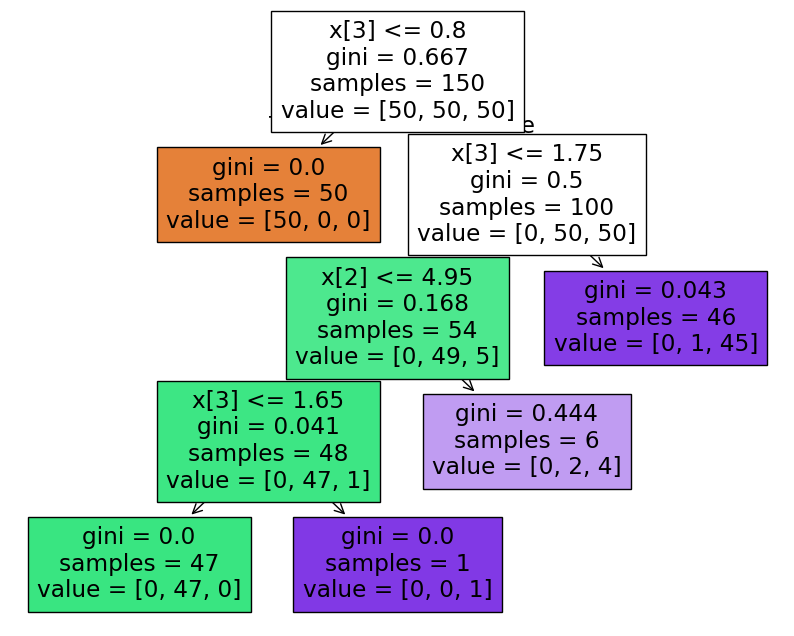

In [232]:
# sklearn's decision tree structure for reference
clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.01)
clf = clf.fit(X, y)
fig = plt.figure(figsize=(10, 8))
tree.plot_tree(clf, filled=True)
plt.savefig("../graph/sklearn_iris.png") # save to the folder for reference
plt.show()

In [233]:
# our implementation
# we set max_depth=5 to match the sklearn tree and min_samples_split=2 to match the default value in sklearn
cart = CART(max_depth=5, min_samples_split=2)
cart.fit(iris_data)
cart.prune(iris_data, ccp_alpha=0.01)
tree_graph = visualize_tree(cart)
tree_graph.render('../graph/CART_iris', format='png', cleanup=True) # save to the graph folder to better organize

0.0 50
0.0 47
0.0 1
0.0 3
0.0 2
0.0 1
0.0 2
0.0 1
0.0 43
0.0 47
0.0 1
0.0 3
0.0 2
0.0 1
0.0 2
0.0 1
0.0 43
0.0 47
0.0 1
0.0 3
0.0 2
0.0 1
0.0 47
0.0 1
0.0 3
0.0 2
0.0 1
0.0 2
0.0 1
0.0 43


'..\\graph\\CART_iris.png'

![](../graph/CART_iris.png)

In [236]:
iris = load_iris()
X = iris.data
y = iris.target
data = np.column_stack((X, y))
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
model = CART(max_depth=3, min_samples_split=10, random_state=0)
# model.fit(train_data)
# model.prune(train_data, ccp_alpha=0.01)
model.fit(data)
model.prune(data, ccp_alpha=0.01)
train_accuracy = model.accuracy(train_data)
test_accuracy = model.accuracy(test_data)
print("For the Iris dataset, here's the accuracy with CART")
print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Testing accuracy: {test_accuracy:.3f}")

0.0 50
0.04079861111111116 48
0.4444444444444444 6
0.4444444444444444 3
0.0 43
For the Iris dataset, here's the accuracy with CART
Training accuracy: 0.325
Testing accuracy: 0.367


In [235]:
iris = load_iris()
X = iris.data
y = iris.target
data = np.column_stack((X, y))
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
model = DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, ccp_alpha=0.01)
model.fit(X_train, y_train)
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))
print("For the Iris dataset, here's the accuracy with sklearn's DecisionTreeClassifier")
print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Testing accuracy: {test_accuracy:.3f}")

For the Iris dataset, here's the accuracy with sklearn's DecisionTreeClassifier
Training accuracy: 0.967
Testing accuracy: 1.000


# Check iris accuracy between CART and scikitlearn

### Using heart.csv

In [237]:
data = np.loadtxt("../data/heart.csv", delimiter=",", skiprows=1)
#train_data, val_data, test_data = train_test_split(data, test_size=0.4, random_state=0)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
#np.savetxt("../data/training_heart.csv", train_data, delimiter=",")
model = CART(max_depth=8, min_samples_split=10, random_state=0, ccp_alpha=0.01)
model.fit(train_data)
model.prune(train_data, ccp_alpha=0.01)
train_accuracy = model.accuracy(train_data)
test_accuracy = model.accuracy(test_data)
print("For the Heart dataset, here's the accuracy with CART")
print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Testing accuracy: {test_accuracy:.3f}")
tree_graph = visualize_tree(model, size=(12,8))
tree_graph.render('../graph/CART_heart', format='png', cleanup=True)

0.0 3
0.0 54
0.31999999999999984 5
0.0 2
0.0 14
0.0 3
0.0 13
0.4444444444444444 3
0.0 8
0.0 13
0.0 4
0.0 47
0.0 5
0.0 3
0.48 5
0.0 45
0.0 145
0.0 3
0.0 22
0.0 18
0.0 2
0.0 4
0.0 7
0.0 2
0.48979591836734704 7
0.0 25
0.0 154
0.0 21
0.0 3
0.0 3
0.0 7
0.0 2
0.5 6
0.375 8
0.0 47
0.0 26
0.4444444444444444 6
0.0 10
0.4444444444444444 6
0.0 6
0.0 12
0.0 3
0.0 2
0.0 36
For the Heart dataset, here's the accuracy with CART
Training accuracy: 0.511
Testing accuracy: 0.522


'..\\graph\\CART_heart.png'

![](../graph/CART_heart.png)

In [181]:
model = DecisionTreeClassifier(max_depth=8, min_samples_split=10, random_state=0, ccp_alpha=0.01)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
model.fit(X_train, y_train)

# Predict on the training and testing datasets
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Compute the accuracies
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# Print the results
print("For the Heart dataset, here's the accuracy with sklearn's DecisionTreeClassifier")
print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Testing accuracy: {test_accuracy:.3f}")

For the Heart dataset, here's the accuracy with sklearn's DecisionTreeClassifier
Training accuracy: 0.876
Testing accuracy: 0.863


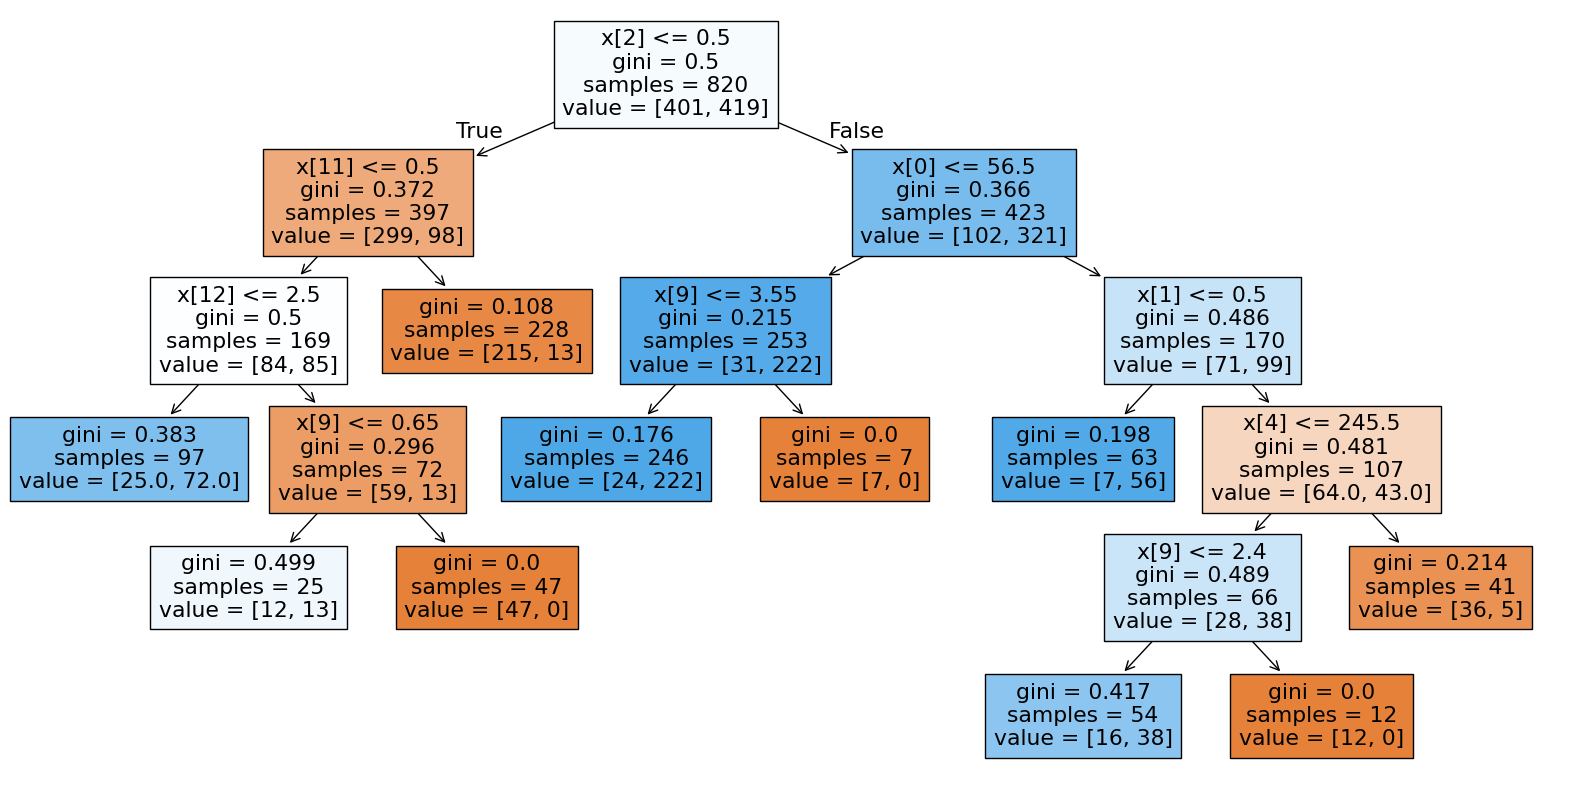

In [182]:
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True)
plt.savefig("../graph/sklearn_heart.png")

As you can see the accuracy and tree structure looks exactly the same. We did a lot of work to reproduce the tree, such as setting Python and numpy's random_state to the same seed, also used sklearn's train-test-split to guarantee a same split. You can also play around with the depth, the accuracy should be the same as well.

# Pruned results

Pruned Scikitlearn implementation:

In [14]:
def manual_cross_val_score(model, X, y, cv=5, random_state = 0, model_type="SKL"):
    '''
    Perform cross validation for the model
    params model: the model
    params X: the features
    params y: the labels
    params cv: the number of folds
    params random_state: the random state
    params model_type: the model type (skl or cart)
    '''
    kf = KFold(n_splits=cv, random_state=random_state, shuffle=True)
    scores = []
    for train_i, val_i in kf.split(X):
        train_X, val_X = X[train_i], X[val_i]
        train_y, val_y = y[train_i], y[val_i]
        if model_type == "SKL":
            clone_model = DecisionTreeClassifier(random_state=model.random_state, ccp_alpha=model.ccp_alpha)
            clone_model.fit(train_X, train_y)
            val_preds = clone_model.predict(val_X)
            score = accuracy_score(val_y, val_preds)
        else:
            clone_model = CART(random_state=model.random_state, ccp_alpha=model.ccp_alpha)
            clone_model.fit(np.column_stack((train_X, train_y)))
            val_preds = clone_model.predict(np.column_stack((val_X, val_y)))
            score = accuracy_score(val_y, val_preds)
        scores.append(score)
    return scores

In [15]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
ccp_alphas = np.linspace(0.0, 0.001, 20)  # 10 values from 0.0 to 0.02

best_alpha = None
best_score = -np.inf
# try to find the best ccp_alpha
for alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    scores = manual_cross_val_score(model, X_train, y_train, cv=5, random_state=0, model_type="SKL")
    mean_score = np.mean(scores)
    if mean_score >= best_score:
        best_score = mean_score
        best_alpha = alpha

print(f"\nBest ccp_alpha: {best_alpha:.8f} with mean CV accuracy: {best_score:.8f}")

best_model = DecisionTreeClassifier(random_state=0, ccp_alpha=0.001)
scores = manual_cross_val_score(model, X_train, y_train, cv=5)
mean_score = np.mean(scores)
print(f"Mean cross-validation score: {mean_score:.8f}")
best_model.fit(X_train, y_train)
test_preds = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds) # get the test accuracy
print(f"Test accuracy with best ccp_alpha={best_alpha:.4f}: {test_accuracy:.4f}")


Best ccp_alpha: 0.00100000 with mean CV accuracy: 0.99268293
Mean cross-validation score: 0.99268293
Test accuracy with best ccp_alpha=0.0010: 1.0000


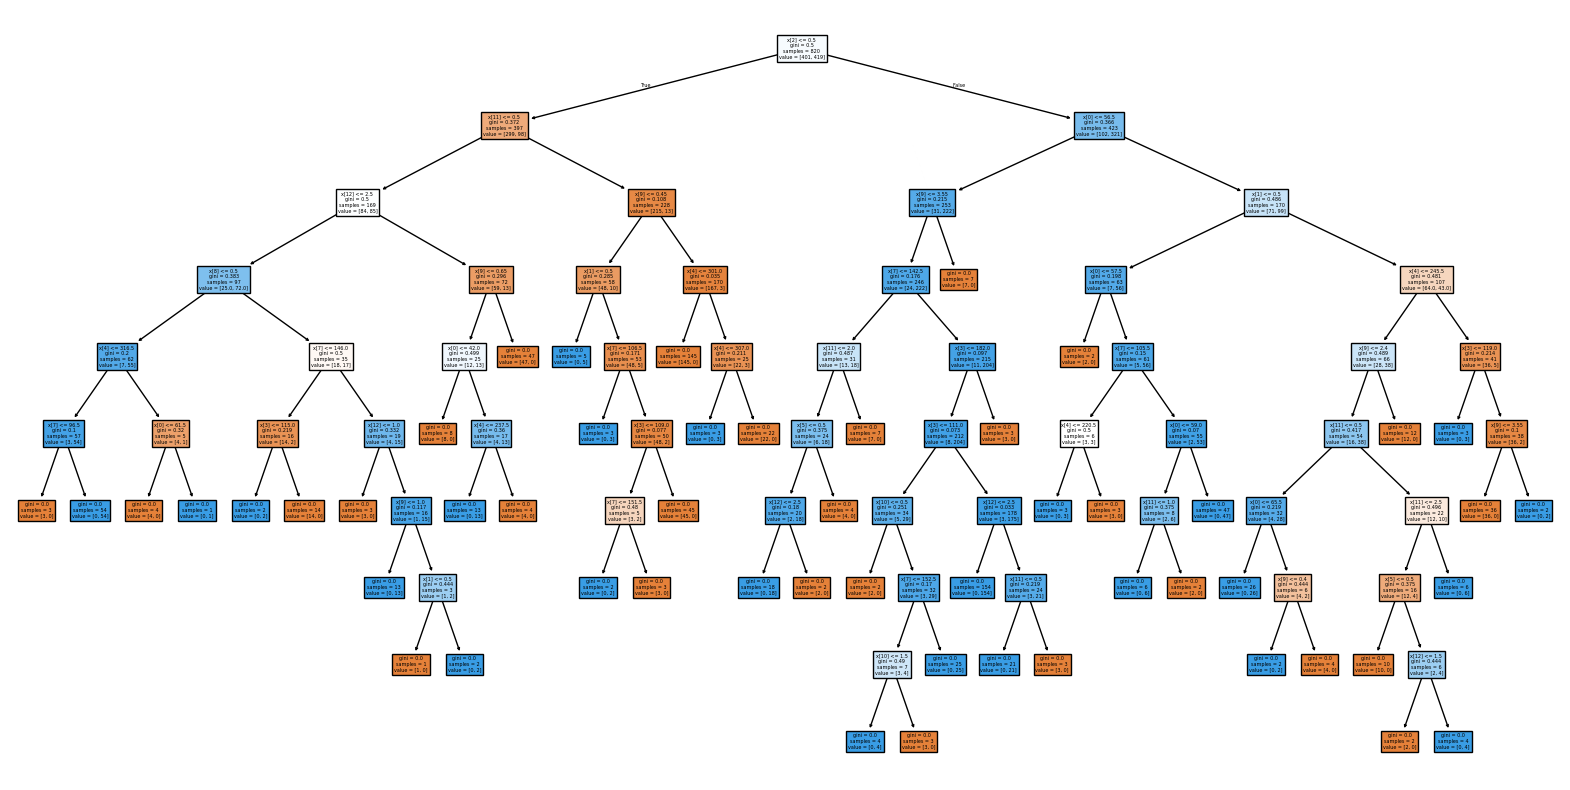

In [16]:
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True)
plt.savefig("../graph/sklearn_heartPrune.png")

CART Pruned implementation

In [183]:
data = np.loadtxt("../data/heart.csv", delimiter=",", skiprows=1)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

model = CART(random_state=0, ccp_alpha=0.001)
scores = manual_cross_val_score(model, X_train, y_train, cv=5, random_state=0, model_type="CART")
mean_score = np.mean(scores)
print(f"Mean cross-validation score: {mean_score:.8f}")
model.fit(np.column_stack((X_train, y_train)))
test_preds = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
print(f"Test accuracy with best ccp_alpha={best_alpha:.4f}: {test_accuracy:.4f}")

tree_graph = visualize_tree(model, size=(12,8))
tree_graph.render('../graph/CART_heartPrune', format='png', cleanup=True)

NameError: name 'manual_cross_val_score' is not defined

In [184]:
# Not pruned 
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

best_model = DecisionTreeClassifier(random_state=0)
scores = manual_cross_val_score(model, X_train, y_train, cv=5)
mean_score = np.mean(scores)
print(f"Mean cross-validation score: {mean_score:.8f}")
best_model.fit(X_train, y_train)
test_preds = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
print("testing acc:", test_accuracy)

NameError: name 'manual_cross_val_score' is not defined

We still achieved similar result for pruning, we can see that the testing accuracy is going up compared to the implementation without pruning. As we can see that our accuracy between not pruning and pruning is very small, which suggest that our model did not overfit, the reason might be because the tree is not a complex tree and it does well in generalizing the dataset.

# Result Overview

As we can see from the above codes, we achieved the same training and testing accuracy and the same tree structure for both dataset (Iris and heart) with both Scikit-learn and our implementation. Then we tried the implementation with pruning optimization, we achieved the same result. 

Updated accuracy:

# Without Pruning

Iris training CART: 0.967

Iris testing CART: 0.967

Iris training Scikit-learn: 0.967

Iris testing Scikit-learn: 0.967

Heart training CART: 0.98

Heart testing CART: 0.946

Heart training Scikit-learn: 0.98

Heart testing Scikit-learn: 0.946

# With Pruning

Iris average pruned CART:

Iris testing CART:

Iris average Scikit-learn:

Iris testing Scikit-learn:

Heart average CART:

Heart testing CART:

Heart average Scikit-learn:

Heart testing Scikit-learn:

# References:

1. Fisher, R. (1936). Iris [Dataset]. UCI Machine Learning Repository. Available at: https://doi.org/10.24432/C56C76/ (Accessed: 1 December 2024).

2. Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1989). Heart Disease [Dataset]. UCI Machine Learning Repository. Available at: https://doi.org/10.24432/C52P4X/ (Accessed: 1 December 2024).

3. Scikit-learn, 2024. Plot Iris Dataset. Available at: https://scikit-learn.org/1.5/auto_examples/datasets/plot_iris_dataset.html/ (Accessed: 1 December 2024)

4. Scikit-learn, 2024. Plot Iris Decision Tree Classifier. Available at: https://scikit-learn.org/1.5/auto_examples/tree/plot_iris_dtc.html (Accessed 1 December 2024).

5. Scikit-learn, 2024. DecisionTreeClassifier. Available at: https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html (Accessed 1 December 2024).

